**Google Drive Connection**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
# Path to the folder containing flower photos
flower_photo_folder = "/content/drive/MyDrive/Colab Notebooks/photos/"

# Path to the selfie folder
selfie_folder = os.path.join(flower_photo_folder, "flower_photos")

**Showing the images**

In [8]:
import os

flower_photo_folder = "/content/drive/MyDrive/Colab Notebooks/photos/flower_photos"

flower_categories = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

image_count = 0

# Iterate through each flower category
for category in flower_categories:
    category_folder = os.path.join(flower_photo_folder, category)
    # Check if category folder exists
    if os.path.exists(category_folder):
        for filename in os.listdir(category_folder):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                image_count += 1

print("Total number of selfie images:", image_count)

Total number of selfie images: 3670


1/1 [==============================] - 0s 208ms/step


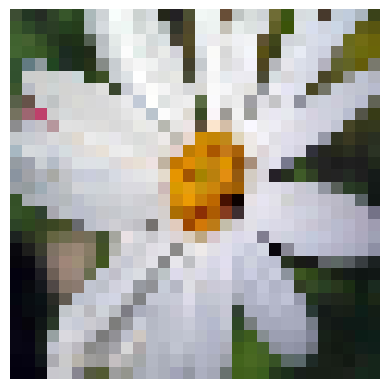

This image most likely belongs to Ellipsis with a 100.00 percent confidence.
1/1 [==============================] - 0s 28ms/step


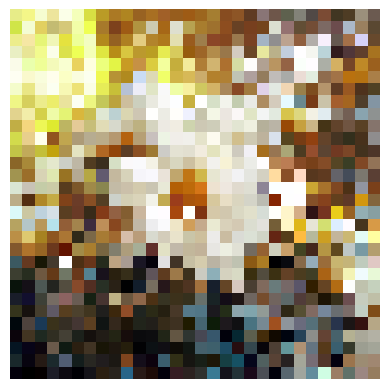

This image most likely belongs to Ellipsis with a 100.00 percent confidence.
1/1 [==============================] - 0s 25ms/step


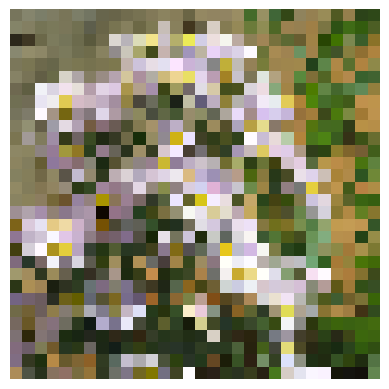

This image most likely belongs to Ellipsis with a 100.00 percent confidence.


In [12]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define or load your TensorFlow model here
# For example, you can define a simple model like this:
num_classes = 1  # Replace 5 with the actual number of classes in your dataset

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Path to the folder containing the images
selfie_folder = "/content/drive/MyDrive/Colab Notebooks/photos/flower_photos/daisy"

# List of image filenames
selfie_filenames = ["43474673_7bb4465a86.jpg", "54377391_15648e8d18.jpg", "99306615_739eb94b9e_m.jpg"]

# Iterate over each image filename
for selfie_filename in selfie_filenames:
    # Path to the image file
    selfie_path = os.path.join(selfie_folder, selfie_filename)

    # Load and preprocess the image
    img = tf.keras.utils.load_img(selfie_path, target_size=(30, 30))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Make predictions
    predictions = model.predict(img_array)
    class_names = [...]  # Define your class names
    score = tf.nn.softmax(predictions[0])

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print prediction results
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))
